In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob
from natsort import natsorted
from tensorflow.keras.preprocessing.image import load_img
import cv2

## Load data

In [60]:
files = glob.glob('../data/train/*')

In [61]:
print('Number of images: ', len(files))

Number of images:  10000


In [62]:
labels = pd.read_csv('./labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])

In [63]:
labels

,id,class,x,y,w,h
0,0,0,158.293543,163.840423,291.767249,291.767249
1,1,0,174.976577,145.041054,285.589838,285.589838
2,2,0,176.162791,156.819932,268.717581,268.717581
3,3,0,257.477453,201.296374,84.595788,84.595788
4,4,0,71.470291,167.118748,133.755485,133.755485
...,...,...,...,...,...,...
9995,9995,1,163.227646,86.690061,209.817385,11.481389
9996,9996,1,149.334399,243.464501,157.174169,146.648070
9997,9997,1,141.026465,240.124885,5.825795,97.160807
9998,9998,1,63.400575,196.567790,125.709731,119.307785


In [64]:
files = natsorted(files)

Load images and lables into numpy arrays 

In [65]:
X = []
for path in files:
    img = load_img(path)
    img_arr = np.asarray(img)
    X.append(img_arr)
    
X = np.array(X)

In [66]:
Y = labels['class']
Y = np.array(Y)

In [67]:
print('Shape of X array: ', X.shape)
print('Shape of Y array: ', Y.shape)
print('Shape of single image: ', X[0].shape)

Shape of X array:  (10000, 320, 320, 3)
Shape of Y array:  (10000,)
Shape of single image:  (320, 320, 3)


Normalize input values to 1

In [86]:
X = X[:,:,:,0]
X = X / X.max()

In [87]:
X.max()

1.0

Custom function to draw bboxes

In [37]:
def draw_bbox(img, xc, yc, w, h):

    start = (int(xc - w / 2), int(yc - h/ 2))
    end = (int(xc + w /2), int(yc + h / 2))
    
    cv2.rectangle(img, start, end, (0,0,255))
    cv2.imshow('bbox', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [38]:
n = 6000
draw_bbox(X[n], labels.loc[n][2], labels.loc[n][3], labels.loc[n][4], labels.loc[n][5])

### Model training

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42, shuffle = True)

In [89]:
print("Original label encoding:",Y_train[0], "shape:", Y_train.shape)
depth = 2

Y_train = tf.one_hot(Y_train, depth)
Y_test = tf.one_hot(Y_test, depth)

print("One hot label encoding for training data:", Y_train[10], "shape:", Y_train.shape)
print("One hot label encoding for test data:",Y_test[1], "shape:", Y_test.shape)

Original label encoding: 1 shape: (7000,)
One hot label encoding for training data: tf.Tensor([0. 1.], shape=(2,), dtype=float32) shape: (7000, 2)
One hot label encoding for test data: tf.Tensor([1. 0.], shape=(2,), dtype=float32) shape: (3000, 2)


Define some helpers

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def printScores(model, X, Y):
    print("Classification report:")
    model.predict(X)
    print(classification_report(Y, np.argmax(model.predict(X), axis = 1)))
    print("Confusion matrix:")
    print(confusion_matrix(Y, np.argmax(model.predict(X), axis = 1)))
    print('Wrong predict:')
    print(confusion_matrix(Y, np.argmax(model.predict(X), axis = 1)).sum() - confusion_matrix(Y, np.argmax(model.predict(X), axis = 1)).trace())
    
    
def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')

Define getModel function with defined CNN model inside - some of the parameters are not used in current version

In [46]:
def getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth):
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    for iHidden in range(nHiddenLayers):   
        #kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)  
        #x = tf.keras.layers.RandomRotation((-0.05, 0.05))(x)
        x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
        x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
        #x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
        x = tf.keras.layers.Dense(int(nNeurons / 2), activation=tf.nn.relu)(x)
        x = tf.keras.layers.Dense(int(nNeurons / 2), activation=tf.nn.relu)(x)



    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#### Train model, print test metrics and plot training history 

Epoch 1/15
93/93 [==============================] - 5692s 62s/step - loss: 0.6447 - accuracy: 0.6108 - val_loss: 0.5914 - val_accuracy: 0.6800
Epoch 2/15
93/93 [==============================] - 101s 1s/step - loss: 0.5862 - accuracy: 0.6659 - val_loss: 0.5879 - val_accuracy: 0.6800
Epoch 3/15
93/93 [==============================] - 103s 1s/step - loss: 0.5585 - accuracy: 0.6945 - val_loss: 0.4674 - val_accuracy: 0.7829
Epoch 4/15
93/93 [==============================] - 103s 1s/step - loss: 0.4663 - accuracy: 0.7837 - val_loss: 0.4266 - val_accuracy: 0.7810
Epoch 5/15
93/93 [==============================] - 102s 1s/step - loss: 0.2626 - accuracy: 0.8847 - val_loss: 0.1802 - val_accuracy: 0.9324
Epoch 6/15
93/93 [==============================] - 102s 1s/step - loss: 0.1698 - accuracy: 0.9247 - val_loss: 0.1247 - val_accuracy: 0.9476
Epoch 7/15
93/93 [==============================] - 101s 1s/step - loss: 0.1580 - accuracy: 0.9229 - val_loss: 0.1083 - val_accuracy: 0.9629
Epoch 8/15


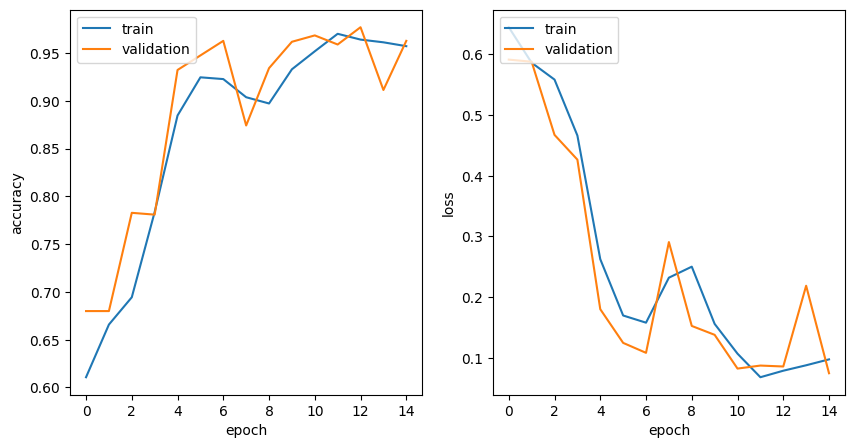

In [59]:
%%time 

dropout_rate = 0.2
l2_lambda = 0.001
batch_size = 64
nFilters = 32
kernel_size = 5
pool_size = (5,5)
nNeurons = 128 
nHiddenLayers = 1 
inputShape = (320, 320, 1)
outputWidth = 2

model = getModel(nFilters, kernel_size, pool_size, nNeurons, nHiddenLayers, dropout_rate, l2_lambda, inputShape, outputWidth)
model_fit = model.fit(X_train, Y_train, epochs=15, batch_size=batch_size, validation_split = 0.15) 
plotTrainingHistory(model_fit)
printScores(model, X_test, np.argmax(Y_test, axis=1))